In [2]:
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from eli5.sklearn import PermutationImportance
import eli5
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest

In [3]:
# ładujemy plik ARFF
with open('Data\Training_Dataset.arff', 'r') as f:
    data, meta = arff.loadarff(f)

# konwertujemy plik na listę list
data_list = data.tolist()

# konwertujemy listę na DataFrame pandas
df = pd.DataFrame(data_list)

# Dodajemy nazwy atrybutów jako kolumny
df.columns = meta.names()

# Konwertujemy każdą wartość na ciąg znaków jeśli to bajt
for col in df.columns:
    df[col] = df[col].apply(lambda x: x.decode() if type(x) == bytes else x)

# DataFrame konwertujemy na typ float
df = df.astype(int)

# Dane są dzielone na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(df.drop('Result', axis=1), df['Result'], test_size=0.25)

# Zamieniamy etykiety
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [142]:
# liczymy ile rekordów jest w DataFrame
num_rows = df.shape[0]

# liczymy ile rekordów jest w zbiorze treningowym
num_rows_train = X_train.shape[0]

# liczymy ile rekordów jest w zbiorze testowym
num_rows_test = X_test.shape[0]

print('Train df size is :' , num_rows_train)
print('Test df size is :' , num_rows_test)
print('Whole df size is :' ,num_rows)
print('Test df + Train df size is :' , num_rows_train + num_rows_test)

Train df size is : 8291
Test df size is : 2764
Whole df size is : 11055
Test df + Train df size is : 11055


In [143]:
# liczenie ilości próbek w każdej z klas
class_counts = df['Result'].value_counts()

# obliczenie proporcji próbek w każdej z klas
class_proportions = class_counts / class_counts.sum()

print(class_proportions)

 1    0.556943
-1    0.443057
Name: Result, dtype: float64


In [144]:
# stwórz listę nazw wszystkich kolumn
attributes_test = df.columns.tolist()

# wydrukuj listę nazw wszystkich kolumn
print(attributes_test)

['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report', 'Result']


In [145]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8291 entries, 2947 to 10778
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            8291 non-null   int32
 1   URL_Length                   8291 non-null   int32
 2   Shortining_Service           8291 non-null   int32
 3   having_At_Symbol             8291 non-null   int32
 4   double_slash_redirecting     8291 non-null   int32
 5   Prefix_Suffix                8291 non-null   int32
 6   having_Sub_Domain            8291 non-null   int32
 7   SSLfinal_State               8291 non-null   int32
 8   Domain_registeration_length  8291 non-null   int32
 9   Favicon                      8291 non-null   int32
 10  port                         8291 non-null   int32
 11  HTTPS_token                  8291 non-null   int32
 12  Request_URL                  8291 non-null   int32
 13  URL_of_Anchor                8291 non-null  

Najlepsze parametry dla Grid Search: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Dokładność dla zbioru treningowego: 0.99
Dokładność dla zbioru testowego: 0.97


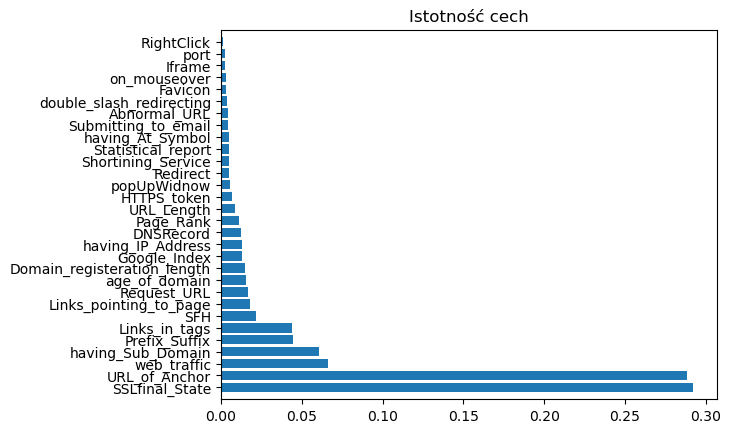

In [4]:
# Decision Tree Grid Search Istotność cech

# Zdefiniowanie parametrów do optymalizacji
param_grid = {'min_samples_leaf': [1, 2, 4],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10]}

#Tworzenie obiektu GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)

#Trenowanie modelu z użyciem GridSearchCV
grid_search.fit(X_train, y_train)

# Pobranie najlepszych parametrów
best_params = grid_search.best_params_

#Wyświetlenie najlepszych parametrów
print('Najlepsze parametry dla Grid Search:', grid_search.best_params_)

# Tworzenie nowego modelu z najlepszymi parametrami
tree = RandomForestClassifier(**best_params)
tree.fit(X_train, y_train)

# Obliczanie dokładności dla zbioru treningowego
tree_train_acc = accuracy_score(y_train, tree.predict(X_train))
print("Dokładność dla zbioru treningowego: {:.2f}".format(tree_train_acc))

# Obliczanie dokładności dla zbioru testowego
tree_test_acc_grid = accuracy_score(y_test, tree.predict(X_test))
print("Dokładność dla zbioru testowego: {:.2f}".format(tree_test_acc_grid))

# Pobieranie istotności cech
importances = tree.feature_importances_

# sortowanie cech według ich istotności
indices = np.argsort(importances)[::-1]

# tworzenie wykresu
plt.title("Istotność cech")
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[indices], fontsize=10)
plt.ylim([-1, X_train.shape[1]])
plt.show()

Cechy zachowane przez RFE:
having_IP_Address
URL_Length
Shortining_Service
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
Domain_registeration_length
HTTPS_token
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Submitting_to_email
popUpWidnow
age_of_domain
DNSRecord
web_traffic
Page_Rank
Google_Index
Links_pointing_to_page
Najlepsze parametry dla Grid Search po RFE: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Dokładność dla zbioru treningowego po RFE: 0.99
Dokładność dla zbioru testowego po RFE: 0.96


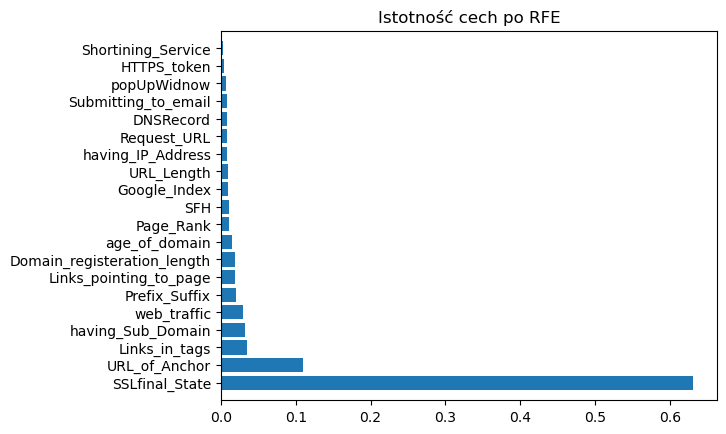

In [5]:
# Decision Tree Grid Search Istotność cech po usunieciu cech ktore nie maja duzego znaczenia

# Tworzenie obiektu RFE
rfe = RFE(tree, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Pobranie nazw cech
feature_names = X_train.columns

# Wypisanie wyniku
print("Cechy zachowane przez RFE:")
for i, feat in enumerate(feature_names):
    if rfe.support_[i]:
        print(feat)

# Tworzenie nowego zbioru danych z wybranymi cechami
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

# Zdefiniowanie parametrów do optymalizacji
param_grid = {'min_samples_leaf': [1, 2, 4],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10]}

#Tworzenie obiektu GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)

#Trenowanie modelu z użyciem GridSearchCV
grid_search.fit(X_train_rfe, y_train)

# Pobranie najlepszych parametrów
best_params = grid_search.best_params_

#Wyświetlenie najlepszych parametrów
print('Najlepsze parametry dla Grid Search po RFE:', grid_search.best_params_)

# Tworzenie i trenowanie modelu na nowym zbiorze danych
tree_rfe = DecisionTreeClassifier(**best_params)
tree_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
tree_rfe_train_acc = accuracy_score(y_train, tree_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(tree_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
tree_rfe_test_acc_grid = accuracy_score(y_test, tree_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(tree_rfe_test_acc_grid))

# Pobieranie istotności cech
importances = tree_rfe.feature_importances_

# sortowanie cech według ich istotności
indices = np.argsort(importances)[::-1]

# tworzenie wykresu
plt.title("Istotność cech po RFE")
plt.barh(range(X_train_rfe.shape[1]), importances[indices])
plt.yticks(range(X_train_rfe.shape[1]), X_train_rfe.columns[indices], fontsize=10)
plt.ylim([-1, X_train_rfe.shape[1]])
plt.show()

In [6]:
# Decision Tree random params po usunięciu nie istotnych cech

# Tworzenie i trenowanie modelu na nowym zbiorze danych
tree_rfe = DecisionTreeClassifier(max_depth=10, min_samples_split=40, min_samples_leaf=20)
tree_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
tree_rfe_train_acc = accuracy_score(y_train, tree_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(tree_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
tree_rfe_test_acc_random_1 = accuracy_score(y_test, tree_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(tree_rfe_test_acc_random_1))

Dokładność dla zbioru treningowego po RFE: 0.94
Dokładność dla zbioru testowego po RFE: 0.93


In [7]:
# Decision Tree random params po usunięciu nie istotnych cech

# Tworzenie i trenowanie modelu na nowym zbiorze danych
tree_rfe = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5)
tree_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
tree_rfe_train_acc = accuracy_score(y_train, tree_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(tree_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
tree_rfe_test_acc_random_2 = accuracy_score(y_test, tree_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(tree_rfe_test_acc_random_2))


Dokładność dla zbioru treningowego po RFE: 0.91
Dokładność dla zbioru testowego po RFE: 0.90


Najlepsze parametry dla Grid Search: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Dokładność dla zbioru treningowego: 0.99
Dokładność dla zbioru testowego: 0.97


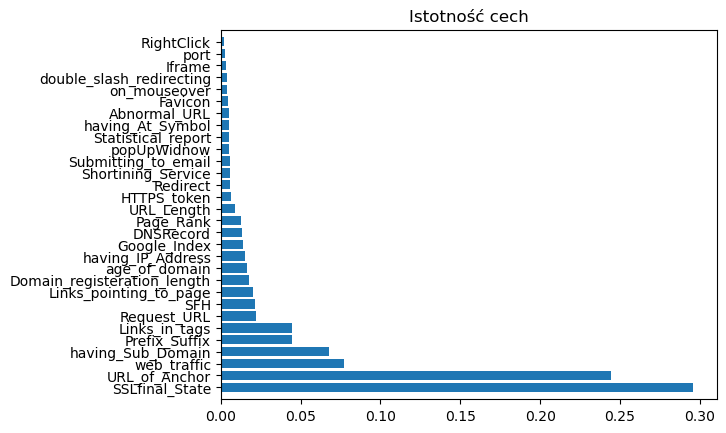

In [8]:
# Random Forest Grid Search Istotność cech

# Zdefiniowanie parametrów do optymalizacji
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2',]}

#Tworzenie obiektu GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)

#Trenowanie modelu z użyciem GridSearchCV
grid_search.fit(X_train, y_train)

# Pobranie najlepszych parametrów
best_params = grid_search.best_params_

#Wyświetlenie najlepszych parametrów
print('Najlepsze parametry dla Grid Search:', grid_search.best_params_)

# Tworzenie nowego modelu z najlepszymi parametrami
forest = RandomForestClassifier(**best_params)
forest.fit(X_train, y_train)

# Obliczanie dokładności dla zbioru treningowego
forest_train_acc = accuracy_score(y_train, forest.predict(X_train))
print("Dokładność dla zbioru treningowego: {:.2f}".format(forest_train_acc))

# Obliczanie dokładności dla zbioru testowego
forest_test_acc_grid = accuracy_score(y_test, forest.predict(X_test))
print("Dokładność dla zbioru testowego: {:.2f}".format(forest_test_acc_grid))

# Pobieranie istotności cech
importances = forest.feature_importances_ #W przypadku losowego lasu (Random Forest), feature_importances oznacza ilość informacji jaką dana cecha przyczynia się do klasyfikacji. Jest to obliczane jako suma ilości drzew, które używają danej cechy, podzielona przez ilość drzew w lesie. Wartości są znormalizowane tak, aby suma wszystkich ważności cech wynosiła 1.

# sortowanie cech według ich istotności
indices = np.argsort(importances)[::-1]

# tworzenie wykresu
plt.title("Istotność cech")
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[indices], fontsize=10)
plt.ylim([-1, X_train.shape[1]])
plt.show()

Cechy zachowane przez RFE:
having_IP_Address
URL_Length
Shortining_Service
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
Domain_registeration_length
HTTPS_token
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Submitting_to_email
popUpWidnow
age_of_domain
DNSRecord
web_traffic
Page_Rank
Google_Index
Links_pointing_to_page
Najlepsze parametry dla Grid Search po RFE: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Dokładność dla zbioru treningowego po RFE: 0.99
Dokładność dla zbioru testowego po RFE: 0.97


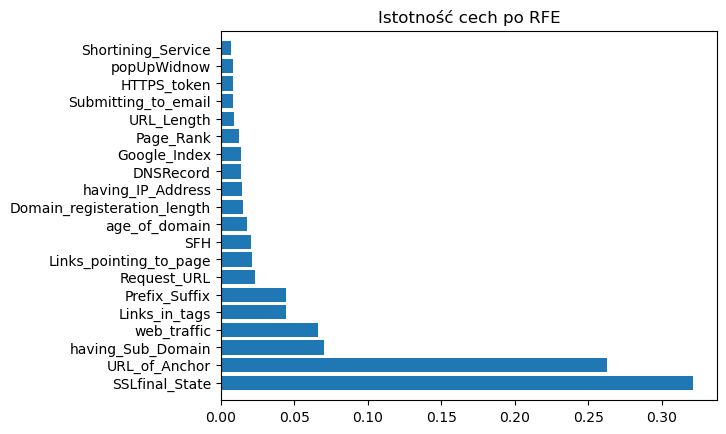

In [9]:
# Random Forest Grid Search Istotność cech po usunieciu nie istotyncyn cech

# Tworzenie obiektu RFE
rfe = RFE(forest, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Pobranie nazw cech
feature_names = X_train.columns

# Wypisanie wyniku
print("Cechy zachowane przez RFE:")
for i, feat in enumerate(feature_names):
    if rfe.support_[i]:
        print(feat)

# Tworzenie nowego zbioru danych z wybranymi cechami
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

# Zdefiniowanie parametrów do optymalizacji
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2']}

#Tworzenie obiektu GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)

#Trenowanie modelu z użyciem GridSearchCV
grid_search.fit(X_train_rfe, y_train)

# Pobranie najlepszych parametrów
best_params = grid_search.best_params_

#Wyświetlenie najlepszych parametrów
print('Najlepsze parametry dla Grid Search po RFE:', grid_search.best_params_)

# Tworzenie i trenowanie modelu na nowym zbiorze danych
forest_rfe = RandomForestClassifier(**best_params)
forest_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
forest_rfe_train_acc = accuracy_score(y_train, forest_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(forest_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
forest_rfe_test_acc_grid = accuracy_score(y_test, forest_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(forest_rfe_test_acc_grid))

# Pobieranie istotności cech
importances = forest_rfe.feature_importances_

# sortowanie cech według ich istotności
indices = np.argsort(importances)[::-1]

# tworzenie wykresu
plt.title("Istotność cech po RFE")
plt.barh(range(X_train_rfe.shape[1]), importances[indices])
plt.yticks(range(X_train_rfe.shape[1]), X_train_rfe.columns[indices], fontsize=10)
plt.ylim([-1, X_train_rfe.shape[1]])
plt.show()

In [10]:
# Random Forest random params po usunieciu nie istotnych cech

# Tworzenie i trenowanie modelu na nowym zbiorze danych
forest_rfe = RandomForestClassifier(n_estimators=50,max_depth=5,min_samples_split=2,min_samples_leaf=1,max_features='sqrt')
forest_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
forest_rfe_train_acc = accuracy_score(y_train, forest_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(forest_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
forest_rfe_test_acc_random_1 = accuracy_score(y_test, forest_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(forest_rfe_test_acc_random_1))

Dokładność dla zbioru treningowego po RFE: 0.93
Dokładność dla zbioru testowego po RFE: 0.92


In [11]:
# Random Forest random params po usunieciu nie istotnych cech

# Tworzenie i trenowanie modelu na nowym zbiorze danych
forest_rfe = RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_split=10,min_samples_leaf=4,max_features='log2')
forest_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
forest_rfe_train_acc = accuracy_score(y_train, forest_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(forest_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
forest_rfe_test_acc_random_2 = accuracy_score(y_test, forest_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(forest_rfe_test_acc_random_2))

Dokładność dla zbioru treningowego po RFE: 0.97
Dokładność dla zbioru testowego po RFE: 0.95


Dokładność dla zbioru treningowego: 0.99
Dokładność dla zbioru treningowego: 0.97


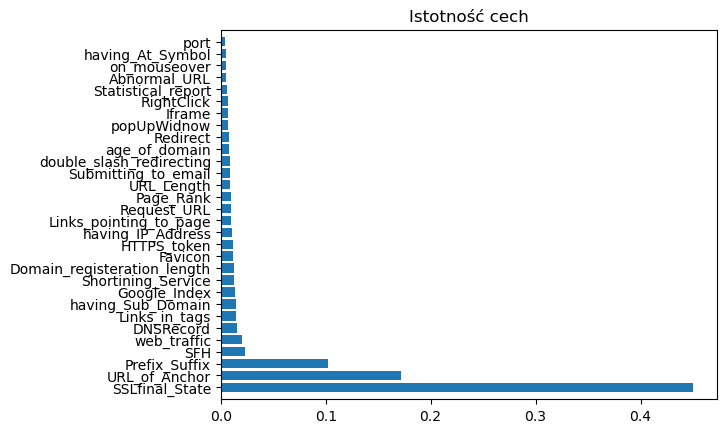

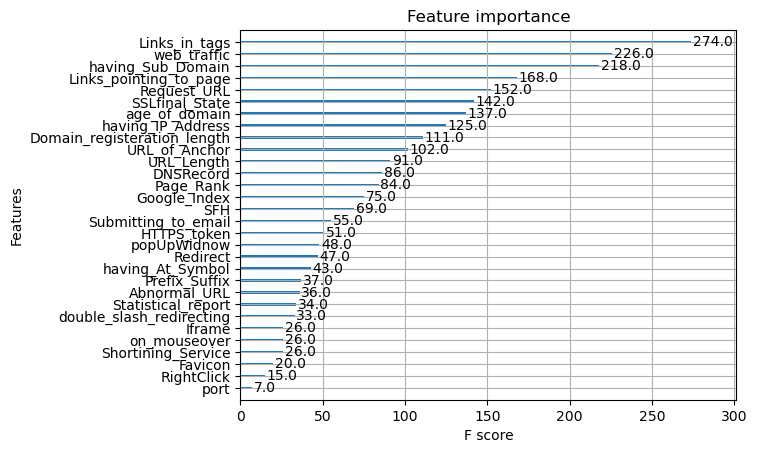

In [19]:
#XGBoost

# Tworzenie i trenowanie modelu xgboost
xgb_clf = xgboost.XGBClassifier(eval_metric='error')
xgb_clf.fit(X_train, y_train)

# Obliczanie dokładności dla zbioru treningowego
xgb_train_acc = accuracy_score(y_train, xgb_clf.predict(X_train))
print("Dokładność dla zbioru treningowego: {:.2f}".format(xgb_train_acc))

# Obliczanie dokładności dla zbioru testowego
xgb_test_acc = accuracy_score(y_test, xgb_clf.predict(X_test))
print("Dokładność dla zbioru treningowego: {:.2f}".format(xgb_test_acc))

# Pobieranie istotności cech
importances = xgb_clf.feature_importances_

# sortowanie cech według ich istotności
indices = np.argsort(importances)[::-1]

# tworzenie wykresu
# plt.figure(figsize=(20, 8))
plt.title("Istotność cech")
plt.barh(range(X_train.shape[1]), importances[indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[indices], fontsize=10)
plt.ylim([-1, X_train.shape[1]])
plt.show()

xgboost.plot_importance(xgb_clf) #Funkcja plot_importance w xgboost używa miara "weight" (waga), która reprezentuje ilość razy dana cecha była używana w drzewach w modelu. Im większa waga, tym cecha jest ważniejsza dla modelu. Możesz również użyć innej miary, takiej jak "cover" (pokrycie) lub "gain" (zysk) za pomocą opcji "importance_type" w funkcji plot_importance.
plt.show()

Cechy zachowane przez RFE:
having_IP_Address
URL_Length
Shortining_Service
double_slash_redirecting
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
Domain_registeration_length
Favicon
HTTPS_token
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Iframe
DNSRecord
web_traffic
Page_Rank
Google_Index
Links_pointing_to_page
Dokładność dla zbioru treningowego: 0.98
Dokładność dla zbioru treningowego: 0.97


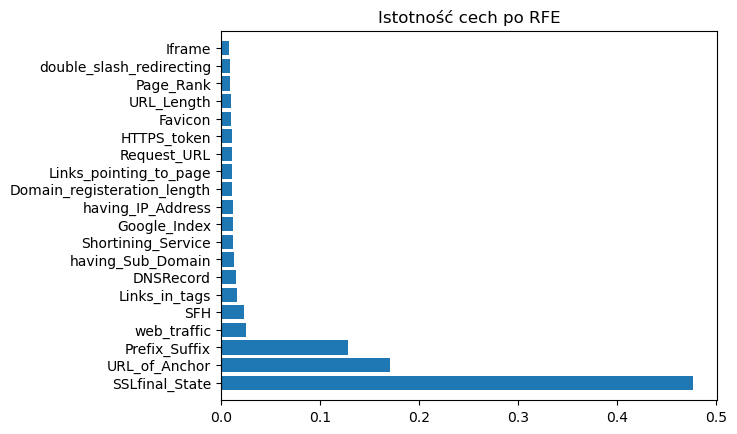

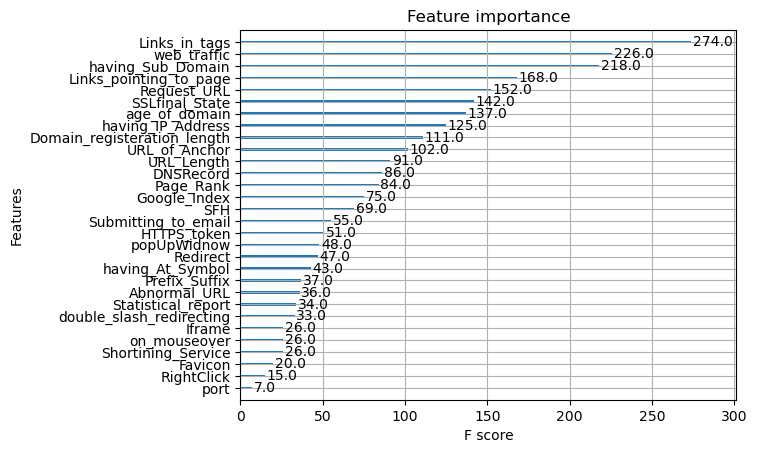

In [21]:
# XGBoost po usunieciu nie istotnych cech

# Tworzenie obiektu RFE
rfe = RFE(xgb_clf, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Pobranie nazw cech
feature_names = X_train.columns

# Wypisanie wyniku
print("Cechy zachowane przez RFE:")
for i, feat in enumerate(feature_names):
    if rfe.support_[i]:
        print(feat)

# Tworzenie nowego zbioru danych z wybranymi cechami
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

# Tworzenie i trenowanie modelu xgboost na nowym zbiorze danych
xgb_clf_rfe = xgboost.XGBClassifier(eval_metric='error')
xgb_clf_rfe.fit(X_train_rfe, y_train)

# Obliczanie dokładności dla zbioru treningowego
xgb_rfe_train_acc = accuracy_score(y_train, xgb_clf_rfe.predict(X_train_rfe))
print("Dokładność dla zbioru treningowego: {:.2f}".format(xgb_rfe_train_acc))

# Obliczanie dokładności dla zbioru testowego
xgb_rfe_test_acc = accuracy_score(y_test, xgb_clf_rfe.predict(X_test_rfe))
print("Dokładność dla zbioru treningowego: {:.2f}".format(xgb_rfe_test_acc))

# Pobieranie istotności cech
importances = xgb_clf_rfe.feature_importances_

# sortowanie cech według ich istotności
indices = np.argsort(importances)[::-1]

# tworzenie wykresu
plt.title("Istotność cech po RFE")
plt.barh(range(X_train_rfe.shape[1]), importances[indices])
plt.yticks(range(X_train_rfe.shape[1]), X_train_rfe.columns[indices], fontsize=10)
plt.ylim([-1, X_train_rfe.shape[1]])
plt.show()

xgboost.plot_importance(xgb_clf) #Funkcja plot_importance w xgboost używa miara "weight" (waga), która reprezentuje ilość razy dana cecha była używana w drzewach w modelu. Im większa waga, tym cecha jest ważniejsza dla modelu. Możesz również użyć innej miary, takiej jak "cover" (pokrycie) lub "gain" (zysk) za pomocą opcji "importance_type" w funkcji plot_importance.
plt.show()

In [14]:
#Sieć neuronowa Grid Search Params Istotność cech

# Zdefiniowanie parametrów do optymalizacji
param_grid = {'hidden_layer_sizes': [(32, 16, 8), (64, 32, 16)],
              'activation': ['relu', 'tanh'],
              'solver': ['adam', 'sgd'],
              'max_iter': [200, 300, 400]}

# Tworzenie obiektu GridSearchCV
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=5, n_jobs=-1)

# Trenowanie modelu z użyciem GridSearchCV
grid_search.fit(X_train, y_train)

# Pobranie najlepszych parametrów
best_params = grid_search.best_params_

# Wyświetlenie najlepszych parametrów
print('Najlepsze parametry dla Grid Search:', grid_search.best_params_)

# Tworzenie nowego modelu z najlepszymi parametrami
mlp_clf = MLPClassifier(**best_params)
mlp_clf.fit(X_train, y_train)

# Obliczanie dokładności dla zbioru treningowego
mlp_train_acc = accuracy_score(y_train, mlp_clf.predict(X_train))
print("Dokładność dla zbioru treningowego: {:.2f}".format(mlp_train_acc))

# Obliczanie dokładności dla zbioru testowego
mlp_test_acc_grid = accuracy_score(y_test, mlp_clf.predict(X_test))
print("Dokładność dla zbioru testowego: {:.2f}".format(mlp_test_acc_grid))

# Tworzenie i trenowanie modelu permutation importance
perm = PermutationImportance(mlp_clf, random_state=0).fit(X_test, y_test)

# Wyświetlanie istotności cech
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Najlepsze parametry dla Grid Search: {'activation': 'tanh', 'hidden_layer_sizes': (64, 32, 16), 'max_iter': 200, 'solver': 'adam'}
Dokładność dla zbioru treningowego: 0.99
Dokładność dla zbioru testowego: 0.97


Weight,Feature
0.1255 ± 0.0125,URL_of_Anchor
0.1007 ± 0.0023,SSLfinal_State
0.0375 ± 0.0056,web_traffic
0.0351 ± 0.0035,Prefix_Suffix
0.0254 ± 0.0058,Links_in_tags
0.0237 ± 0.0052,having_Sub_Domain
0.0226 ± 0.0079,Request_URL
0.0221 ± 0.0027,Links_pointing_to_page
0.0177 ± 0.0031,age_of_domain
0.0163 ± 0.0036,Page_Rank


In [15]:
# Sieć neuronowa Grid Search Po usunieciu nie istotnych cech

# Tworzenie obiektu SelectKBest
selector = SelectKBest(k=20)
selector.fit(X_train, y_train)

# Pobieranie nazw cech
feature_names = X_train.columns

# Wypisanie wyniku
print("Cechy zachowane przez SelectKBest:")
for i, feat in enumerate(feature_names):
    if selector.get_support()[i]:
        print(feat)

# Tworzenie nowego zbioru danych z wybranymi cechami
X_train_kbest = selector.transform(X_train)
X_test_kbest = selector.transform(X_test)

# Zdefiniowanie parametrów do optymalizacji
param_grid = {'hidden_layer_sizes': [(32, 16, 8), (64, 32, 16)],
              'activation': ['relu', 'tanh'],
              'solver': ['adam', 'sgd'],
              'max_iter': [200, 300, 400]}

# Tworzenie obiektu GridSearchCV
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=5, n_jobs=-1)

# Trenowanie modelu z użyciem GridSearchCV
grid_search.fit(X_train_kbest, y_train)

# Pobranie najlepszych parametrów
best_params = grid_search.best_params_

# Wyświetlenie najlepszych parametrów
print('Najlepsze parametry dla Grid Search po RFE:', grid_search.best_params_)

# Tworzenie i trenowanie modelu na nowym zbiorze danych
mlp_kbest = MLPClassifier(**best_params)
mlp_kbest.fit(X_train_kbest, y_train)

# Obliczanie dokładności dla nowego zbioru treningowego
mlp_kbest_train_acc = accuracy_score(y_train, mlp_kbest.predict(X_train_kbest))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(mlp_kbest_train_acc))

# Obliczanie dokładności dla nowego zbioru testowego
mlp_kbest_test_acc_grid = accuracy_score(y_test, mlp_kbest.predict(X_test_kbest))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(mlp_kbest_test_acc_grid))

# Tworzenie i trenowanie modelu permutation importance
perm = PermutationImportance(mlp_kbest, random_state=0).fit(X_test_kbest, y_test)

# Wyświetlanie istotności cech
eli5.show_weights(perm, feature_names = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]])

Cechy zachowane przez SelectKBest:
having_IP_Address
URL_Length
Shortining_Service
having_At_Symbol
Prefix_Suffix
having_Sub_Domain
SSLfinal_State
Domain_registeration_length
Request_URL
URL_of_Anchor
Links_in_tags
SFH
Abnormal_URL
on_mouseover
age_of_domain
DNSRecord
web_traffic
Page_Rank
Google_Index
Statistical_report
Najlepsze parametry dla Grid Search po RFE: {'activation': 'tanh', 'hidden_layer_sizes': (64, 32, 16), 'max_iter': 200, 'solver': 'adam'}
Dokładność dla zbioru treningowego po RFE: 0.98
Dokładność dla zbioru testowego po RFE: 0.95


Weight,Feature
0.1148 ± 0.0076,URL_of_Anchor
0.0839 ± 0.0081,SSLfinal_State
0.0298 ± 0.0047,web_traffic
0.0284 ± 0.0015,Prefix_Suffix
0.0257 ± 0.0081,having_Sub_Domain
0.0196 ± 0.0046,SFH
0.0168 ± 0.0018,Links_in_tags
0.0148 ± 0.0046,age_of_domain
0.0145 ± 0.0050,DNSRecord
0.0137 ± 0.0022,Request_URL


In [16]:
# Sieć neuronowa random params po usunięciu nie istotnych cech

# Tworzenie i trenowanie modelu na nowym zbiorze danych
mlp_kbest = MLPClassifier(hidden_layer_sizes=(32, 16, 8), activation='relu', solver='adam', max_iter=300)
mlp_kbest.fit(X_train_kbest, y_train)

# Obliczanie dokładności dla nowego zbioru treningowego
mlp_kbest_train_acc = accuracy_score(y_train, mlp_kbest.predict(X_train_kbest))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(mlp_kbest_train_acc))

# Obliczanie dokładności dla nowego zbioru testowego
mlp_kbest_test_acc_random_1 = accuracy_score(y_test, mlp_kbest.predict(X_test_kbest))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(mlp_kbest_test_acc_random_1))

# Tworzenie i trenowanie modelu permutation importance
perm = PermutationImportance(mlp_kbest, random_state=0).fit(X_test_kbest, y_test)

# Wyświetlanie istotności cech
eli5.show_weights(perm, feature_names = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]])

Dokładność dla zbioru treningowego po RFE: 0.98
Dokładność dla zbioru testowego po RFE: 0.95


Weight,Feature
0.1146 ± 0.0072,URL_of_Anchor
0.0807 ± 0.0050,SSLfinal_State
0.0404 ± 0.0016,Prefix_Suffix
0.0295 ± 0.0058,web_traffic
0.0216 ± 0.0034,having_Sub_Domain
0.0213 ± 0.0029,Links_in_tags
0.0196 ± 0.0055,SFH
0.0195 ± 0.0083,age_of_domain
0.0145 ± 0.0061,Domain_registeration_length
0.0135 ± 0.0021,Request_URL


In [17]:
# Sieć neuronowa random params po usunięciu nie istotnych cech

# Tworzenie i trenowanie modelu na nowym zbiorze danych
mlp_kbest = MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='tanh', solver='sgd', max_iter=500)
mlp_kbest.fit(X_train_kbest, y_train)

# Obliczanie dokładności dla nowego zbioru treningowego
mlp_kbest_train_acc = accuracy_score(y_train, mlp_kbest.predict(X_train_kbest))
print("Dokładność dla zbioru treningowego po RFE: {:.2f}".format(mlp_kbest_train_acc))

# Obliczanie dokładności dla nowego zbioru testowego
mlp_kbest_test_acc_random_2 = accuracy_score(y_test, mlp_kbest.predict(X_test_kbest))
print("Dokładność dla zbioru testowego po RFE: {:.2f}".format(mlp_kbest_test_acc_random_2))

# Tworzenie i trenowanie modelu permutation importance
perm = PermutationImportance(mlp_kbest, random_state=0).fit(X_test_kbest, y_test)

# Wyświetlanie istotności cech
eli5.show_weights(perm, feature_names = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]])

C:\Users\Madzia\anaconda3\envs\env_tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Dokładność dla zbioru treningowego po RFE: 0.96
Dokładność dla zbioru testowego po RFE: 0.95


Weight,Feature
0.1111 ± 0.0066,URL_of_Anchor
0.0921 ± 0.0054,SSLfinal_State
0.0517 ± 0.0070,Prefix_Suffix
0.0255 ± 0.0044,web_traffic
0.0166 ± 0.0033,having_Sub_Domain
0.0161 ± 0.0049,SFH
0.0161 ± 0.0055,Links_in_tags
0.0102 ± 0.0021,Request_URL
0.0094 ± 0.0035,URL_Length
0.0082 ± 0.0049,Google_Index


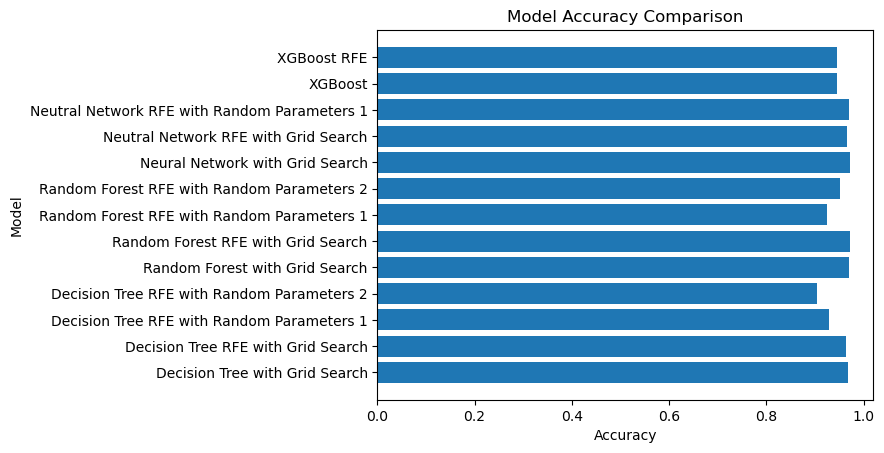

In [18]:
#Porównanie wszystkich modeli poprzez accuracy_score

accuracies = [tree_test_acc_grid,tree_rfe_test_acc_grid,tree_rfe_test_acc_random_1,tree_rfe_test_acc_random_2,forest_test_acc_grid, forest_rfe_test_acc_grid,forest_rfe_test_acc_random_1, forest_rfe_test_acc_random_2,
 xgb_test_acc, xgb_rfe_test_acc, mlp_test_acc_grid, mlp_kbest_test_acc_grid, mlp_kbest_test_acc_random_1, mlp_kbest_test_acc_random_2]

model_names = ['Decision Tree with Grid Search', 'Decision Tree RFE with Grid Search' ,'Decision Tree RFE with Random Parameters 1' ,'Decision Tree RFE with Random Parameters 2','Random Forest with Grid Search', 'Random Forest RFE with Grid Search', 'Random Forest RFE with Random Parameters 1', 'Random Forest RFE with Random Parameters 2','Neural Network with Grid Search', 'Neutral Network RFE with Grid Search', 'Neutral Network RFE with Random Parameters 1','Neutral Network RFE with Random Parameters 1', 'XGBoost', 'XGBoost RFE']

plt.title('Model Accuracy Comparison')
plt.barh(model_names, accuracies)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()